In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os,glob
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import accuracy_score
#import imutils
# from keras.preprocessing.image import img_to_array
# from sklearn import svm

In [3]:
CLASS = ["Parasitized","Uninfected"]
LABELS = {
    "Parasitized" : 0,
    "Uninfected" : 1,
}

dataset_train = "Data/train"
dataset_test = "Data/test"
data_test_path = "dataset/test"

In [4]:
def generate_imagepath(base_path):
    temp = []
    for types in CLASS: 
        df = pd.DataFrame()
        base_dir = os.path.join(base_path,types)
        files = glob.glob(base_dir+'/*.png')
        y = [LABELS[types]]*len(files)
        df["FILE"] = files
        df["OUTPUT"] = y
        temp.append(df)
    return pd.concat(temp).reset_index(drop=True)

In [5]:
def generate_imagepath_test(base_path):
    df = pd.DataFrame()
    files = glob.glob(base_path+'/*.png')
    df["FILE"] = files
    return df.reset_index(drop=True)

In [6]:
def read_image(img_path):
    image = cv2.resize(cv2.imread(img_path),(100,100))
    return image

In [7]:
def load_dataset(df,size=100,shuffle=True):
    x = []
    y = []
    if(shuffle):
        df = df.sample(frac=1).reset_index(drop=True)
    for index, row in df.iterrows():
        if(index<size):
            x.append(read_image(row["FILE"]))
            y.append(row["OUTPUT"])
        else:
            print(index)
            break
    return [x,y]

In [8]:
def load_dataset_test(df):
    x = []
    for index, row in df.iterrows():
        x.append(read_image(row["FILE"]))
    return x

In [10]:
def show_image(image):
    try:
        plt.imshow(image[:, :, [2, 1, 0]])
        plt.show()
    except:
        plt.imshow(image, cmap="gray")
        plt.show()

In [11]:
data_train = generate_imagepath(dataset_train)
data_test = generate_imagepath(dataset_test)
data_test_new = generate_imagepath_test(data_test_path)
# data_test.shape
# [x_train,y_train] = load_dataset(data_train,3000)
# [x_test,y_test] = load_dataset(data_test,5512)
x_test = load_dataset_test(data_test_new)

In [13]:
print(len(x_test))

1587


## Preprocessing

In [14]:
def change_contrast(image,alpha = 1.5,beta=25):
    # Contrast control (1.0-3.0)
    # Brightness control (0-100)
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

In [147]:
def image_cleanup(image):
    blurred = cv2.GaussianBlur(image, (3, 3), cv2.BORDER_DEFAULT)
    thresh = cv2.threshold(blurred, 175, 250, cv2.THRESH_BINARY)[1]
    return thresh

In [16]:
def remove_noisy_regions(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    mask = cv2.erode(gray, element, iterations = 50)
    mask = cv2.dilate(mask, element, iterations = 50)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    mask = cv2.erode(gray, element, iterations = 1)
    mask = cv2.dilate(mask, element, iterations = 1)
    mask = cv2.erode(mask, element)
    gray = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    return gray

In [17]:
def preprocess(image):
    i1 = change_contrast(image,1.5,25)
    i2 = image_cleanup(i1)
    img = remove_noisy_regions(i2)
    h,s,v = cv2.split(img)
    ab = cv2.subtract(h,s)
#     th, threshed = cv2.threshold(s, 100, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return ab

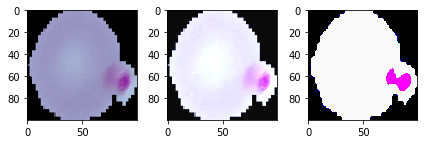

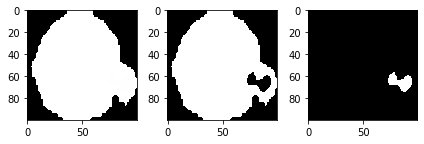

In [118]:
num = 11
lll = x_test[num]
llll = x_test[num+1]
# ab = preprocess(lll)
# show_image(lll)
# show_image(ab)

i1 = change_contrast(lll,1.5,10)
i2 = image_cleanup(i1)
img = remove_noisy_regions(i2)
h,s,v = cv2.split(img)
ab = cv2.subtract(h,s)


i11 = change_contrast(llll,1.5,10)
i22 = image_cleanup(i11)
img12 = remove_noisy_regions(i22)
h1,s1,v1 = cv2.split(img12)
ab12 = cv2.subtract(h1,s1)

# th, threshed = cv2.threshold(s, 100, 255, cv2.THRESH_BINARY)


fig,asx = plt.subplots(1,3)
asx[0].imshow(lll,cmap="gray")
asx[1].imshow(i1,cmap="gray")
asx[2].imshow(i2,cmap="gray")
fig.tight_layout()
plt.savefig("contrast.png",dpi=300)

fig,asx = plt.subplots(1,3)
asx[0].imshow(h,cmap="gray")
asx[1].imshow(s,cmap="gray")
asx[2].imshow(ab,cmap="gray")
fig.tight_layout()
plt.savefig("processing.png",dpi=300)
# show_image(lll)
# show_image(i1)
# show_image(i2)
# show_image(h)
# show_image(s)
# show_image(ab)

## Blob Detection

In [18]:
def find_contours_and_centers(img_input):
    contours_raw, hierarchy = cv2.findContours(img_input, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = [i for i in contours_raw]
    contour_centers = []
    
    for idx, c in enumerate(contours):
        M = cv2.moments(c)
        try:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        except:
            cX = int(M["m10"] / (M["m00"] + 0.0001))
            cY = int(M["m01"] / (M["m00"] + 0.0001))
        samp_bounds = cv2.boundingRect(c)
        contour_centers.append(((cX,cY), samp_bounds))
    contour_centers = sorted(contour_centers, key=lambda x: x[0])

    return (contours, contour_centers)

2
1


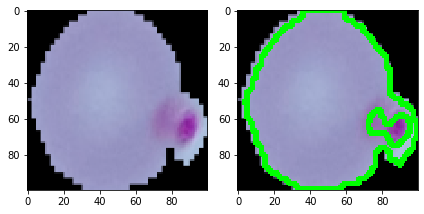

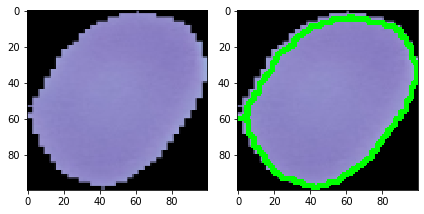

In [122]:
conts, cents = find_contours_and_centers(s)
# circles = [i for i in conts if np.logical_and((cv2.contourArea(i) > 650),(cv2.contourArea(i) < 4000))]
print(len(cents))
img = lll.copy()
cv2.drawContours(img, conts, -1, (0,255,0), 2)
# show_image(img)

conts, cents = find_contours_and_centers(s1)
# circles = [i for i in conts if np.logical_and((cv2.contourArea(i) > 650),(cv2.contourArea(i) < 4000))]
print(len(cents))
img111 = llll.copy()
cv2.drawContours(img111, conts, -1, (0,255,0), 2)
# show_image(img111)

fig,asx = plt.subplots(1,2)
asx[0].imshow(lll)
asx[1].imshow(img,cmap="gray")
fig.tight_layout()
plt.savefig("contour_infected.png",dpi=300)
fig,asx = plt.subplots(1,2)
asx[0].imshow(llll)
asx[1].imshow(img111,cmap="gray")
fig.tight_layout()
plt.savefig("contour.png",dpi=300)

## Prediction

In [143]:
def preprocess(image):
    i1 = change_contrast(image,1.95,15)
    i2 = image_cleanup(i1)
    img = remove_noisy_regions(i2)
    h,s,v = cv2.split(img)
    ab = cv2.subtract(h,s)
#     th, threshed = cv2.threshold(s, 100, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return ab

In [74]:
count = 0
total = 0
prob_i = []
prob = []
prob_y = []
for i in range(len(x_test)):
    im_processed = preprocess(x_test[i])
    try:
        conts, cents = find_contours_and_centers(im_processed)
    except:
        continue
    if(len(cents) >= 1 and y_test[i] == 0):
        count +=1 
    elif(len(cents) == 0 and y_test[i] == 1):
        count +=1
    else: 
        prob.append(x_test[i])
        prob_y.append(y_test[i])
    total += 1
print(count/total)

0.9357764876632801


In [148]:
y_out = []
total = 0
count = 0
for i in range(len(x_test)):
    im_processed = preprocess(x_test[i])
    conts, cents = find_contours_and_centers(im_processed)
    if(len(cents) >= 1):
        y_out.append(1)
    else:
        y_out.append(0)
    total += 1

In [72]:
print(count)
print(total)
print(len(prob))

0
1587


NameError: name 'prob' is not defined

In [149]:
# data_test_new.columns = ["Name"]
data_test_new["Label"] = y_out
data_test_new.to_csv("output.csv", encoding='utf-8', index=False)

In [150]:
n=0
count=0
df1 = pd.read_csv('answers.csv')
df2 = pd.read_csv('output.csv')
for i in range(len(df1.values)):
    n+=1
    if(df1.Label.values[i]==df2.Label.values[i]):
        count+=1
count/n

0.9269061121613107

## Feature Extraction Using OpenCV

In [404]:
def extract_features(image,vector_size=20):
    algo = cv2.xfeatures2d.SURF_create()
    kps, dsc = algo.detectAndCompute(image,None)
    combined = zip(kps,dsc)
    combined = list(combined)
    combined.sort(key = lambda x: x[0].response,reverse=True)
    combined = combined[0:vector_size]
    dsc = [x[1] for x in combined]
    kps = [x[0] for x in combined]
    return [image,kps,dsc]

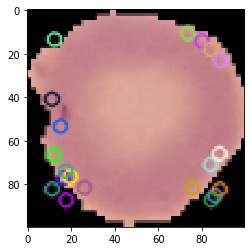

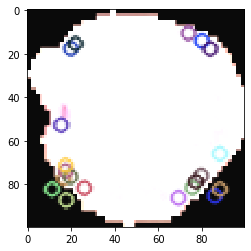

In [409]:
kps_size = 20
[img1,kps1,des1] = extract_features(lll,kps_size)
[img2,kps2,des2] = extract_features(i1,kps_size)
copy1 = cv2.drawKeypoints(img1,kps1, outImage = None)
copy2 = cv2.drawKeypoints(img2,kps2, outImage = None)
show_image(copy1)
show_image(copy2)

## Model Building

In [52]:
def calculate_histogram(images, model,n):
    feature_vectors=[]
    for image in images :
        img = preprocess(image)
        [img,kps,des] = extract_features(img)
        predict_kmeans = model.predict(des)
        hist, bin_edges = np.histogram(predict_kmeans, bins = n)
        feature_vectors.append(hist)
    feature_vectors=np.asarray(feature_vectors)
    return np.array(feature_vectors)

In [57]:
sift_keypoints = []
num_of_clusters= 20

for image in x_train :
    img = preprocess(image)
    [img,kps,des] = extract_features(img)
    sift_keypoints.append(des)
sift_keypoints = np.concatenate(sift_keypoints, axis=0)
kmeans = KMeans(n_clusters = num_of_clusters).fit(sift_keypoints)
sift_keypoints.shape

TypeError: zip argument #2 must support iteration

In [ ]:
x_feat_train = calculate_histogram(x_train, kmeans,num_of_clusters)
x_feat_test = calculate_histogram(x_test, kmeans,num_of_clusters)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(x_feat_train, y_train);

y_pred = rf.predict(x_feat_test)
accuracy_score(y_pred, y_test)